# Example 05: Loss Functions and Metrics

The choice of loss function and evaluation metrics significantly affects
training behavior and how you assess model quality. TSFast provides
specialized losses and metrics for time series system identification:

- **Loss modifiers** that wrap any base loss to skip transients, slice
  windows, or normalize scales
- **Evaluation metrics** standard in the system identification literature

This example walks through each one and explains when to use it.

## Prerequisites

This example builds on concepts from Examples 00-02. Make sure you have
completed those first.

## Setup

In [1]:
from torch import nn

from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.learner.losses import (
    fun_rmse, nrmse, nrmse_std, mean_vaf,
    weighted_mae, NormLoss, SkipNLoss, CutLoss,
)

## Load Dataset

We use the Silverbox benchmark throughout this example. Each model trains for
only 5 epochs to keep things fast -- the focus here is on the loss and metric
behavior, not on achieving the best possible fit.

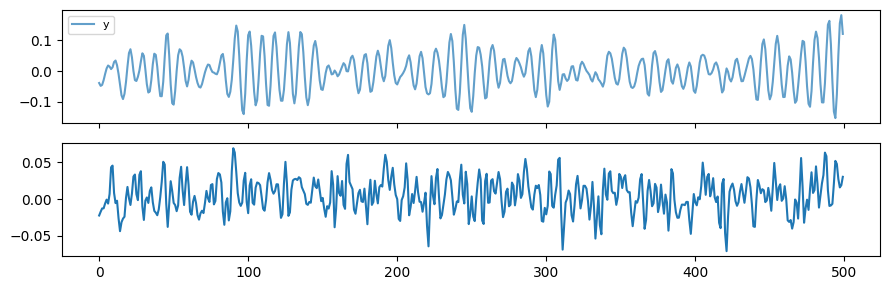

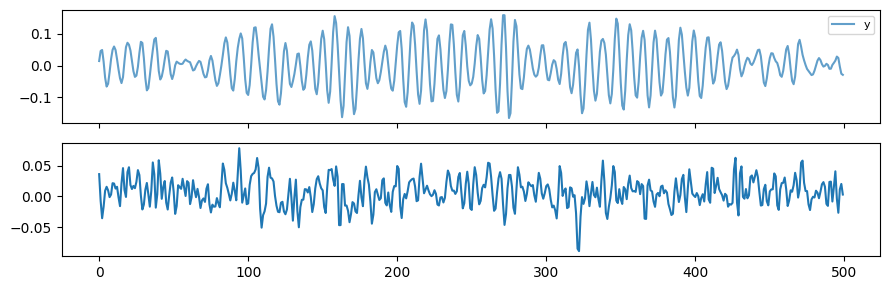

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls.show_batch(max_n=2)

## The Default: MAE Loss

TSFast uses `nn.L1Loss()` (Mean Absolute Error) as the default training loss.
MAE is more robust to outliers and measurement spikes than MSE (Mean Squared
Error). MSE heavily penalizes large errors, which can cause the model to
overfit to noisy data points. For system identification, where measurement
noise and occasional spikes are common, MAE provides a more stable training
signal.

In [3]:
lrn_mae = RNNLearner(dls, rnn_type='lstm', loss_func=nn.L1Loss(), metrics=[fun_rmse])
lrn_mae.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.007598,0.008758,0.013008,00:03
1,0.005556,0.004273,0.010027,00:02
2,0.005291,0.003553,0.009784,00:02
3,0.005207,0.008866,0.013140,00:02
4,0.002889,0.002946,0.009638,00:02


## Evaluation Metrics

While you train with a loss function, you evaluate with metrics. TSFast
provides several standard metrics for system identification:

- **`fun_rmse`** -- Root Mean Square Error. The standard reporting metric in
  many fields. Penalizes large errors more than MAE because of the squaring.

- **`nrmse`** -- RMSE normalized by the variance of each target variable.
  This allows fair comparison across outputs with different scales. A value
  of 0 means perfect prediction; a value of 1 means the model is no better
  than predicting the mean.

- **`nrmse_std`** -- RMSE normalized by the standard deviation of each target
  variable. Similar to `nrmse` but uses std instead of variance for the
  denominator.

- **`mean_vaf`** -- Variance Accounted For, expressed as a percentage. Measures
  what fraction of the target signal's variance is explained by the model.
  100% means perfect prediction. This metric is widely used in the system
  identification literature.

In [4]:
lrn = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse, nrmse, nrmse_std, mean_vaf])
lrn.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,nrmse,nrmse_std,mean_vaf,time
0,0.006300,0.007040,0.011418,0.210085,0.048976,95.576324,00:03
1,0.005771,0.006037,0.010643,0.195835,0.045653,96.148384,00:03
2,0.004965,0.006523,0.011075,0.203767,0.047504,95.857437,00:03
3,0.004895,0.004078,0.009756,0.179511,0.041848,96.765434,00:03
4,0.002968,0.002979,0.009521,0.175204,0.040843,96.914482,00:03


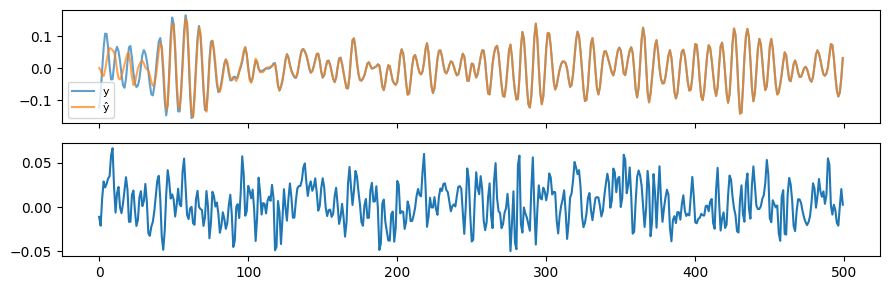

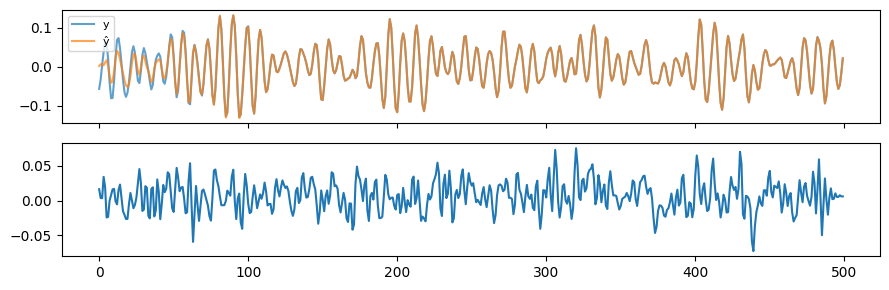

In [5]:
lrn.show_results(max_n=2)

## SkipNLoss: Ignoring Transient Warmup

RNNs start from a zero hidden state. During the first few timesteps, the
hidden state is "warming up" and predictions are unreliable. `SkipNLoss`
wraps any loss function to discard the first N timesteps from the loss
computation. This prevents the optimizer from wasting effort on the
unavoidable warmup transient.

- **`n_skip=50`** -- skip the first 50 timesteps when computing the loss

In [6]:
skip_loss = SkipNLoss(nn.L1Loss(), n_skip=50)
lrn_skip = RNNLearner(dls, rnn_type='lstm', loss_func=skip_loss, metrics=[fun_rmse])
lrn_skip.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.004727,0.005117,0.012157,00:03
1,0.004544,0.004348,0.011204,00:03
2,0.003434,0.002807,0.010370,00:04
3,0.003260,0.006804,0.012994,00:03
4,0.000956,0.000876,0.009895,00:03


## CutLoss: Evaluating a Window

`CutLoss` slices the sequence to a specific range before computing the loss.
This is useful when you only care about predictions in a particular part of
the sequence.

- **`l_cut=50`** -- trim 50 timesteps from the left (start of the sequence)
- **`r_cut=450`** -- keep up to timestep 450 (trim from the right)

This evaluates only timesteps 50 through 450 of each 500-step window.

In [7]:
cut_loss = CutLoss(nn.L1Loss(), l_cut=50, r_cut=450)
lrn_cut = RNNLearner(dls, rnn_type='lstm', loss_func=cut_loss, metrics=[fun_rmse])
lrn_cut.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.005346,0.002203,0.010908,00:03
1,0.003702,0.006528,0.012890,00:03
2,0.002936,0.003210,0.010516,00:03
3,0.003453,0.002412,0.010168,00:04
4,0.000963,0.000935,0.009889,00:03


## NormLoss: Scale-Invariant Training

When your system has multiple outputs with very different magnitudes (e.g.,
position in meters and velocity in m/s), the loss is dominated by the
largest-scale output. `NormLoss` normalizes both predictions and targets
before computing the loss, so all outputs contribute equally regardless of
their physical scale.

`NormLoss` takes the output normalization statistics from the DataLoaders
(`dls.norm_stats.y`) and uses them to normalize both prediction and target
tensors before passing them to the base loss function.

In [8]:
norm_loss = NormLoss(nn.L1Loss(), dls.norm_stats.y)
lrn_norm = RNNLearner(dls, rnn_type='lstm', loss_func=norm_loss, metrics=[fun_rmse])
lrn_norm.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.107327,0.070765,0.009799,00:03
1,0.100861,0.079307,0.009826,00:03
2,0.100530,0.101081,0.010465,00:03
3,0.097980,0.136098,0.011828,00:04
4,0.053633,0.054801,0.009550,00:04


## Weighted MAE

`weighted_mae` applies log-spaced weights along the time axis, giving higher
weight to earlier timesteps and lower weight to later ones. This is useful
when early dynamics matter more than steady-state behavior, for example when
modeling transient responses or step responses where the initial trajectory is
most informative.

In [9]:
lrn_wmae = RNNLearner(dls, rnn_type='lstm', loss_func=weighted_mae, metrics=[fun_rmse])
lrn_wmae.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009629,0.012127,0.014360,00:04
1,0.007964,0.008791,0.010841,00:04
2,0.007672,0.007494,0.009977,00:03
3,0.007458,0.006848,0.009710,00:04
4,0.005981,0.006298,0.009603,00:04


## Key Takeaways

- **MAE (default)** is robust to outliers -- a good default for system
  identification where measurement noise and spikes are common.
- **`fun_rmse`**, **`nrmse`**, and **`mean_vaf`** are standard evaluation
  metrics. `nrmse` enables fair comparison across different-scale outputs,
  and `mean_vaf` reports the percentage of variance explained.
- **`SkipNLoss`** excludes the RNN warmup transient from the loss, preventing
  the optimizer from fitting the unavoidable zero-state startup.
- **`CutLoss`** restricts the loss to a specific time window, useful when
  only part of the sequence matters.
- **`NormLoss`** enables scale-invariant training for multi-output systems by
  computing the loss in normalized space.
- **`weighted_mae`** emphasizes early timesteps, useful for transient-response
  modeling.
- Choose metrics that match your evaluation requirements -- different
  applications call for different measures of model quality.